In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import cv2
import pickle

In [2]:
def init_tumor_ellipse(size,a,b,cx,cy,radius):
    #cx,cy = int(size/2),int(size/2)
    x, y = np.indices((size, size))
    phi = (np.abs(np.hypot((x-cx)/a, (y-cy)/b)) < radius).astype(float)
    return phi

In [3]:
def broaden_interface(vessels,sigma,iterations):
    for i in np.arange(iterations):
        vessels = cv2.GaussianBlur(vessels,(sigma,sigma),0)
    return vessels

In [4]:
def init_s2(size):
    s = 2.55 + 0.4 * np.random.rand(size,size)
    return s

In [5]:
ductimg = cv2.imread('prostateschemes/prostate.png')
vesselimg = cv2.imread('prostateschemes/vessels_bw.png')
ducts = (ductimg[:,:,0]>128).astype(float)
vessels = (vesselimg[:,:,0]>128).astype(float)
ducts = broaden_interface(ducts,9,3)
#plt.imshow(ducts, cmap='gray')

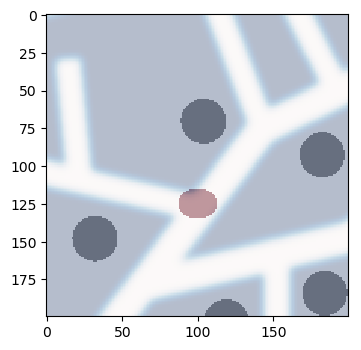

In [6]:
# create 200 px versions
xstart, ystart = 110,75
size = 200
ducts200 = np.copy(ducts[xstart:xstart+size,ystart:ystart+size])
vessels200 = np.copy(vessels[xstart:xstart+size,ystart:ystart+size])
tumor = init_tumor_ellipse(size,1,1.3,125,100,10)
#tumor[tumor==0]= np.nan
fig, ax = plt.subplots(dpi=100)
#ax.imshow(vessels200 == ducts200, cmap = 'gray')
ax.imshow(vessels200, cmap = 'gray')
ax.imshow(ducts200, alpha=0.5, cmap = 'Blues')
ax.imshow(tumor, alpha=0.4, cmap = 'Reds')

In [7]:
# introduce new parameter d (for duct): 0 in duct, 1 outside
def fintegrate_nophi(phi, sigma, S, dt, h, d, **kwargs):
    """
      try to go even faster
      -> don't create copy here
      -> try to reduce multiplications
      -> cv2 for convolution?
      integrate the order parameter phi and the chemical field sigma one tstep
      with 5x5 stencil (five point stencil - https://en.wikipedia.org/wiki/Five-point_stencil)
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    stencil_5 = (1.0 / (12.0 * h * h)) * np.array(
        [[0, 0, -1, 0, 0],
         [0, 0, 16, 0, 0],
         [-1, 16, -60, 16, -1],
         [0, 0, 16, 0, 0],
         [0, 0, -1, 0, 0]])
    # (1-d*(1-phi))
    #((1-d)*phi)
    phinew = phi + dt * ( (1-d*phi) * (kwargs['lambda_'] * cv2.filter2D(phi,-1,stencil_5,borderType=cv2.BORDER_REPLICATE) +
                      (64.0/kwargs['tau']) * phi * (1.0 - phi) * (phi - 0.5) ) +
                      kwargs['chi'] * sigma - kwargs['A'] * phi)

    sigmanew = sigma + dt * (kwargs['epsilon']*kwargs['lambda_'] * cv2.filter2D(sigma,-1,stencil_5,borderType=cv2.BORDER_REPLICATE) +
                              S - kwargs['delta'] * phi - kwargs['gamma'] * sigma)    

    return phinew, sigmanew

In [13]:
def run_partest(phistart, sigmastart, Sstart, d, param):
    print("running parameter test with parameters", param)
    phiold = np.copy(phistart)
    sigmaold = np.copy(sigmastart)
    S = np.copy(Sstart)
    phiarr = np.zeros((param['days'],size,size)) #take care, size not derived from input!
    sigmaarr = np.zeros((param['days'],size,size))
    
    tstep = param['days']/param['dt']
    
    for iteration in np.arange(tstep):
        phinew, sigmanew = fintegrate_nophi(phiold, sigmaold, S, d=d, **param)
        phiold = phinew
        sigmaold = sigmanew

        if iteration%int(1/param['dt']) == 0:
            phiarr[int(iteration*param['dt'])]=phinew
            sigmaarr[int(iteration*param['dt'])]=sigmanew
            print("day",iteration*param['dt'])
            #plt.imshow(phiold,vmin=0,vmax=1)
            #plt.imshow(sigmaold,vmin=0,vmax=3)
            #plt.show()    
    results = {'param':param,'phistart':phistart,'sigmastart':sigmastart,'Sstart':Sstart,'phiarr':phiarr,'sigmaarr':sigmaarr}
    return results

In [14]:
Avals = list(np.arange(0.3,2.0,0.1))
#Avals = [1.1]
chivals = [1.09]

In [15]:
size = 200
phistart = init_tumor_ellipse(size,1,1.3,125,100,10)
sigmastart = np.ones((size,size),dtype=float)
Sstart = init_s2(size)
param = {'dt':0.00025, 'h':5., 'lambda_':432., 'epsilon':40., 
         'A':1.2, 'gamma':2.74, 'tau':3.65, 'chi':1.09, 'delta':2.75, 'days':365}

for A in Avals:
    for chi in chivals:
        param['A'] = A
        param['chi'] = chi
        res = run_partest(phistart, sigmastart, Sstart, ducts200, param)
        
        filename = 'parvariation_duct/A_'+str(A)+'_chi_'+str(chi)+'.pickle'
        with open(filename, 'wb') as handle:
            pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

running parameter test with parameters {'chi': 1.09, 'gamma': 2.74, 'dt': 0.00025, 'days': 365, 'lambda_': 432.0, 'epsilon': 40.0, 'h': 5.0, 'delta': 2.75, 'tau': 3.65, 'A': 0.29999999999999999}
day 0.0
day 1.0
day 2.0


/home/alunos/.conda/envs/prost/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/home/alunos/.conda/envs/prost/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/home/alunos/.conda/envs/prost/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in subtract
/home/alunos/.conda/envs/prost/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in subtract


day 3.0
day 4.0
day 5.0
day 6.0
day 7.0
day 8.0
day 9.0
day 10.0
day 11.0
day 12.0
day 13.0
day 14.0
day 15.0
day 16.0
day 17.0
day 18.0
day 19.0
day 20.0
day 21.0
day 22.0
day 23.0
day 24.0
day 25.0
day 26.0
day 27.0
day 28.0
day 29.0
day 30.0
day 31.0
day 32.0
day 33.0
day 34.0
day 35.0
day 36.0
day 37.0
day 38.0
day 39.0
day 40.0
day 41.0
day 42.0
day 43.0
day 44.0
day 45.0
day 46.0
day 47.0
day 48.0
day 49.0
day 50.0
day 51.0
day 52.0
day 53.0
day 54.0
day 55.0
day 56.0
day 57.0
day 58.0
day 59.0
day 60.0
day 61.0
day 62.0
day 63.0
day 64.0
day 65.0
day 66.0
day 67.0
day 68.0
day 69.0
day 70.0
day 71.0
day 72.0
day 73.0
day 74.0
day 75.0
day 76.0
day 77.0
day 78.0
day 79.0
day 80.0
day 81.0
day 82.0
day 83.0
day 84.0
day 85.0
day 86.0
day 87.0
day 88.0
day 89.0
day 90.0
day 91.0
day 92.0
day 93.0
day 94.0
day 95.0
day 96.0
day 97.0
day 98.0
day 99.0
day 100.0
day 101.0
day 102.0
day 103.0
day 104.0
day 105.0
day 106.0
day 107.0
day 108.0
day 109.0
day 110.0
day 111.0
day 112.0
day 

day 86.0
day 87.0
day 88.0
day 89.0
day 90.0
day 91.0
day 92.0
day 93.0
day 94.0
day 95.0
day 96.0
day 97.0
day 98.0
day 99.0
day 100.0
day 101.0
day 102.0
day 103.0
day 104.0
day 105.0
day 106.0
day 107.0
day 108.0
day 109.0
day 110.0
day 111.0
day 112.0
day 113.0
day 114.0
day 115.0
day 116.0
day 117.0
day 118.0
day 119.0
day 120.0
day 121.0
day 122.0
day 123.0
day 124.0
day 125.0
day 126.0
day 127.0
day 128.0
day 129.0
day 130.0
day 131.0
day 132.0
day 133.0
day 134.0
day 135.0
day 136.0
day 137.0
day 138.0
day 139.0
day 140.0
day 141.0
day 142.0
day 143.0
day 144.0
day 145.0
day 146.0
day 147.0
day 148.0
day 149.0
day 150.0
day 151.0
day 152.0
day 153.0
day 154.0
day 155.0
day 156.0
day 157.0
day 158.0
day 159.0
day 160.0
day 161.0
day 162.0
day 163.0
day 164.0
day 165.0
day 166.0
day 167.0
day 168.0
day 169.0
day 170.0
day 171.0
day 172.0
day 173.0
day 174.0
day 175.0
day 176.0
day 177.0
day 178.0
day 179.0
day 180.0
day 181.0
day 182.0
day 183.0
day 184.0
day 185.0
day 186.0
day 

day 160.0
day 161.0
day 162.0
day 163.0
day 164.0
day 165.0
day 166.0
day 167.0
day 168.0
day 169.0
day 170.0
day 171.0
day 172.0
day 173.0
day 174.0
day 175.0
day 176.0
day 177.0
day 178.0
day 179.0
day 180.0
day 181.0
day 182.0
day 183.0
day 184.0
day 185.0
day 186.0
day 187.0
day 188.0
day 189.0
day 190.0
day 191.0
day 192.0
day 193.0
day 194.0
day 195.0
day 196.0
day 197.0
day 198.0
day 199.0
day 200.0
day 201.0
day 202.0
day 203.0
day 204.0
day 205.0
day 206.0
day 207.0
day 208.0
day 209.0
day 210.0
day 211.0
day 212.0
day 213.0
day 214.0
day 215.0
day 216.0
day 217.0
day 218.0
day 219.0
day 220.0
day 221.0
day 222.0
day 223.0
day 224.0
day 225.0
day 226.0
day 227.0
day 228.0
day 229.0
day 230.0
day 231.0
day 232.0
day 233.0
day 234.0
day 235.0
day 236.0
day 237.0
day 238.0
day 239.0
day 240.0
day 241.0
day 242.0
day 243.0
day 244.0
day 245.0
day 246.0
day 247.0
day 248.0
day 249.0
day 250.0
day 251.0
day 252.0
day 253.0
day 254.0
day 255.0
day 256.0
day 257.0
day 258.0
day 259.0


day 233.0
day 234.0
day 235.0
day 236.0
day 237.0
day 238.0
day 239.0
day 240.0
day 241.0
day 242.0
day 243.0
day 244.0
day 245.0
day 246.0
day 247.0
day 248.0
day 249.0
day 250.0
day 251.0
day 252.0
day 253.0
day 254.0
day 255.0
day 256.0
day 257.0
day 258.0
day 259.0
day 260.0
day 261.0
day 262.0
day 263.0
day 264.0
day 265.0
day 266.0
day 267.0
day 268.0
day 269.0
day 270.0
day 271.0
day 272.0
day 273.0
day 274.0
day 275.0
day 276.0
day 277.0
day 278.0
day 279.0
day 280.0
day 281.0
day 282.0
day 283.0
day 284.0
day 285.0
day 286.0
day 287.0
day 288.0
day 289.0
day 290.0
day 291.0
day 292.0
day 293.0
day 294.0
day 295.0
day 296.0
day 297.0
day 298.0
day 299.0
day 300.0
day 301.0
day 302.0
day 303.0
day 304.0
day 305.0
day 306.0
day 307.0
day 308.0
day 309.0
day 310.0
day 311.0
day 312.0
day 313.0
day 314.0
day 315.0
day 316.0
day 317.0
day 318.0
day 319.0
day 320.0
day 321.0
day 322.0
day 323.0
day 324.0
day 325.0
day 326.0
day 327.0
day 328.0
day 329.0
day 330.0
day 331.0
day 332.0


day 306.0
day 307.0
day 308.0
day 309.0
day 310.0
day 311.0
day 312.0
day 313.0
day 314.0
day 315.0
day 316.0
day 317.0
day 318.0
day 319.0
day 320.0
day 321.0
day 322.0
day 323.0
day 324.0
day 325.0
day 326.0
day 327.0
day 328.0
day 329.0
day 330.0
day 331.0
day 332.0
day 333.0
day 334.0
day 335.0
day 336.0
day 337.0
day 338.0
day 339.0
day 340.0
day 341.0
day 342.0
day 343.0
day 344.0
day 345.0
day 346.0
day 347.0
day 348.0
day 349.0
day 350.0
day 351.0
day 352.0
day 353.0
day 354.0
day 355.0
day 356.0
day 357.0
day 358.0
day 359.0
day 360.0
day 361.0
day 362.0
day 363.0
day 364.0
running parameter test with parameters {'chi': 1.09, 'gamma': 2.74, 'dt': 0.00025, 'days': 365, 'lambda_': 432.0, 'epsilon': 40.0, 'h': 5.0, 'delta': 2.75, 'tau': 3.65, 'A': 1.2000000000000004}
day 0.0
day 1.0
day 2.0
day 3.0
day 4.0
day 5.0
day 6.0
day 7.0
day 8.0
day 9.0
day 10.0
day 11.0
day 12.0
day 13.0
day 14.0
day 15.0
day 16.0
day 17.0
day 18.0
day 19.0
day 20.0
day 21.0
day 22.0
day 23.0
day 24.0
d

day 1.0
day 2.0
day 3.0
day 4.0
day 5.0
day 6.0
day 7.0
day 8.0
day 9.0
day 10.0
day 11.0
day 12.0
day 13.0
day 14.0
day 15.0
day 16.0
day 17.0
day 18.0
day 19.0
day 20.0
day 21.0
day 22.0
day 23.0
day 24.0
day 25.0
day 26.0
day 27.0
day 28.0
day 29.0
day 30.0
day 31.0
day 32.0
day 33.0
day 34.0
day 35.0
day 36.0
day 37.0
day 38.0
day 39.0
day 40.0
day 41.0
day 42.0
day 43.0
day 44.0
day 45.0
day 46.0
day 47.0
day 48.0
day 49.0
day 50.0
day 51.0
day 52.0
day 53.0
day 54.0
day 55.0
day 56.0
day 57.0
day 58.0
day 59.0
day 60.0
day 61.0
day 62.0
day 63.0
day 64.0
day 65.0
day 66.0
day 67.0
day 68.0
day 69.0
day 70.0
day 71.0
day 72.0
day 73.0
day 74.0
day 75.0
day 76.0
day 77.0
day 78.0
day 79.0
day 80.0
day 81.0
day 82.0
day 83.0
day 84.0
day 85.0
day 86.0
day 87.0
day 88.0
day 89.0
day 90.0
day 91.0
day 92.0
day 93.0
day 94.0
day 95.0
day 96.0
day 97.0
day 98.0
day 99.0
day 100.0
day 101.0
day 102.0
day 103.0
day 104.0
day 105.0
day 106.0
day 107.0
day 108.0
day 109.0
day 110.0
day 111.

day 83.0
day 84.0
day 85.0
day 86.0
day 87.0
day 88.0
day 89.0
day 90.0
day 91.0
day 92.0
day 93.0
day 94.0
day 95.0
day 96.0
day 97.0
day 98.0
day 99.0
day 100.0
day 101.0
day 102.0
day 103.0
day 104.0
day 105.0
day 106.0
day 107.0
day 108.0
day 109.0
day 110.0
day 111.0
day 112.0
day 113.0
day 114.0
day 115.0
day 116.0
day 117.0
day 118.0
day 119.0
day 120.0
day 121.0
day 122.0
day 123.0
day 124.0
day 125.0
day 126.0
day 127.0
day 128.0
day 129.0
day 130.0
day 131.0
day 132.0
day 133.0
day 134.0
day 135.0
day 136.0
day 137.0
day 138.0
day 139.0
day 140.0
day 141.0
day 142.0
day 143.0
day 144.0
day 145.0
day 146.0
day 147.0
day 148.0
day 149.0
day 150.0
day 151.0
day 152.0
day 153.0
day 154.0
day 155.0
day 156.0
day 157.0
day 158.0
day 159.0
day 160.0
day 161.0
day 162.0
day 163.0
day 164.0
day 165.0
day 166.0
day 167.0
day 168.0
day 169.0
day 170.0
day 171.0
day 172.0
day 173.0
day 174.0
day 175.0
day 176.0
day 177.0
day 178.0
day 179.0
day 180.0
day 181.0
day 182.0
day 183.0
day 184

day 158.0
day 159.0
day 160.0
day 161.0
day 162.0
day 163.0
day 164.0
day 165.0
day 166.0
day 167.0
day 168.0
day 169.0
day 170.0
day 171.0
day 172.0
day 173.0
day 174.0
day 175.0
day 176.0
day 177.0
day 178.0
day 179.0
day 180.0
day 181.0
day 182.0
day 183.0
day 184.0
day 185.0
day 186.0
day 187.0
day 188.0
day 189.0
day 190.0
day 191.0
day 192.0
day 193.0
day 194.0
day 195.0
day 196.0
day 197.0
day 198.0
day 199.0
day 200.0
day 201.0
day 202.0
day 203.0
day 204.0
day 205.0
day 206.0
day 207.0
day 208.0
day 209.0
day 210.0
day 211.0
day 212.0
day 213.0
day 214.0
day 215.0
day 216.0
day 217.0
day 218.0
day 219.0
day 220.0
day 221.0
day 222.0
day 223.0
day 224.0
day 225.0
day 226.0
day 227.0
day 228.0
day 229.0
day 230.0
day 231.0
day 232.0
day 233.0
day 234.0
day 235.0
day 236.0
day 237.0
day 238.0
day 239.0
day 240.0
day 241.0
day 242.0
day 243.0
day 244.0
day 245.0
day 246.0
day 247.0
day 248.0
day 249.0
day 250.0
day 251.0
day 252.0
day 253.0
day 254.0
day 255.0
day 256.0
day 257.0
